In [22]:
import os
import json
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv
from azure.search.documents import SearchClient
load_dotenv()

aoai_endpoint = os.getenv("AZURE_OPENAI_API_BASE")
aoai_key = os.getenv("AZURE_OPENAI_API_KEY")
aoai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")
aoai_chat_model = os.getenv("AZURE_OPENAI_MODEL")
aoai_chat_model_mini = os.getenv("AZURE_OPENAI_MODEL_MINI")
aoai_embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")
search_endpoint = os.getenv("SEARCH_ENDPOINT")
search_key = os.getenv("SEARCH_KEY")
search_index = os.getenv("SEARCH_INDEX")
credential = AzureKeyCredential(search_key)

chunk_file_path = "synthetic_data_generator/config/chunks.json"
synthetic_questions_file_path = "synthetic_data_generator/output/synthetic_data.json"

# Get Data From Index to Base Synthetic Data

In [6]:
"Get 500 chunks from index"

search_client = SearchClient(endpoint=search_endpoint, index_name=search_index, credential=credential)

results = search_client.search(
    search_text="*",
    top=500
)

for document in results:

    data = {"content": document["chunk"], "chunk_id": document["chunk_id"]}

    if os.path.exists(chunk_file_path):
        with open(chunk_file_path, 'r', encoding='utf-8') as file:
            try:
                existing_data = json.load(file)
                if not isinstance(existing_data, list):
                    existing_data = []
            except json.JSONDecodeError:
                existing_data = []
    else:
        existing_data = []

    existing_data.append(data)

    with open(chunk_file_path, 'w', encoding='utf-8') as file:
        json.dump(existing_data, file, indent=4)



# Generate Synthetic Data

In [16]:
from synthetic_data_generator.data_generator import generate_data

generate_data(
    chunk_path=chunk_file_path,
    injection_folder_path="synthetic_data_generator/config/injections",
    context_file_path="synthetic_data_generator/config/context.json",
    length_config_file="synthetic_data_generator/config/response_lengh_distrubution.json",
    number_of_generated_rows=5,
    output_file_path=synthetic_questions_file_path
)

Config you Search here

In [17]:
def get_search_results(query, index):
    try:
        # perform search query
        search_client = SearchClient(endpoint=search_endpoint, index_name=index, credential=credential)
        results = search_client.search(
            search_text=query,
            top=4,
        )

        # format search results
        data = []
        for result in results:
            data.append(
                {
                    "chunk_id": result["chunk_id"],
                }
            )
        return data
    except Exception as e:
        print(e)
        return None

Loop through the data and see if the correct chunk was retrived

In [20]:
import json

with open(synthetic_questions_file_path, 'r') as file:
    questions = json.load(file)

results = []

for entry in questions:
    question = entry.get("question")
    expected_chunk_id = entry.get("chunk_id")
    
    chunk_ids = get_search_results(query=question, index=search_index)

    results.append(expected_chunk_id in chunk_ids)
    


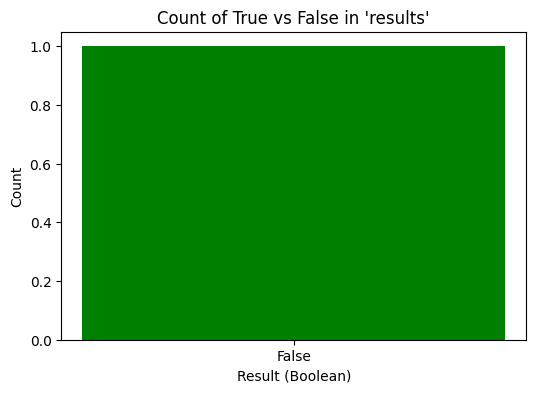

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'results' is already populated with booleans
counts = Counter(results)  # Count True and False values

# Prepare data for plotting using a bar graph
labels = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['green', 'red'])
plt.xlabel("Result (Boolean)")
plt.ylabel("Count")
plt.title("Count of True vs False in 'results'")
plt.xticks(labels, [str(label) for label in labels])
plt.show()